In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [42]:
class Catagorization:
    def __init__(self, num_ants, num_rules_converge, data, attributes, classes):
        self.num_ants = num_ants
        self.num_rules_converge = num_rules_converge
        self.data = data
        self.original_data = data.copy()
        self.attributes = attributes

        self.classes = classes
        self.heuristic = self.calc_heuristic()
        self.pharamones = self.init_pharamones()
        self.discovered_rules = {}
        self.qualities = [[]]
        self.leftover_cases = len(self.data) * 0.15
        self.init_ants() 
        
    def init_ants(self):
        min_cases = round(len(self.original_data) * 0.05)
        self.ants = [Ant(self.pharamones, self.heuristic, self.attributes, min_cases, self.classes) for i in range(self.num_ants)]
        
    def run_simulation(self):
        while len(self.data) > self.leftover_cases:
            self.converged_rules = 1
            best_rule = []
            best_quality = -1
            consequent = None
            
            for j, ant in enumerate(self.ants):
                self.run_one_ant(ant)
                
                    
                if best_quality < 0 and set(self.ants[j-1].rule) == set(ant.rule) and ant.rule:
                    self.converged_rules += 1
                else:
                    self.converged_rules = 1
                if self.converged_rules == self.num_rules_converge:
                    print('rules have converged')
                    break
                if ant.quality > best_quality:
                    best_quality = ant.quality
                    best_rule = ant.rule
                    consequent = ant.consequent
            n = self.remove_relevant_cases(best_rule, consequent)
            print(len(self.data))
            res = self.discovered_rules.get(consequent, [])
            res.append((best_rule, best_quality, n))
            self.discovered_rules[consequent] = res
            self.pharamones = self.init_pharamones()
            self.init_ants()
            self.qualities.append([])
        print('simulation done. Remaining cases: ', len(self.data))
            
    def run_one_ant(self, ant):
        ant.pharamones = self.pharamones
        ant.add_terms(self.data)
        q = self.prune_ant(ant)
        consequent = self.calc_consequent(ant.rule)
        self.update_pharamones(ant.rule, q)
        ant.quality = q
        ant.consequent = consequent
        self.qualities[-1].append(q)
        
    def calc_heuristic(self):
        total_num = len(self.classes)
        for attribute in self.attributes.keys():
            total_num *= len(self.attributes[attribute])
            
#         total_num = len(self.attributes.keys())*len(self.attributes.values())*len(self.classes)
        probs = {}
        heuristic = {}
        for index, i in enumerate(self.attributes.keys()):
            for j in self.attributes[i]:
                for k in self.classes:
                    a = [game for game in self.data if k == game[-1]]
                    b = [game for game in a if j == game[index]]
                    p = len(b)/len(self.data)
                    c = probs.get((index,j),[])
                    c.append(np.log2(p**p))
                    probs[(index,j)] = c
                heuristic[(index,j)] = -sum(probs[(index,j)])
        return heuristic

    def pick_best_rule(self):
        most_correct = 0
        best_ant = None
        for ant in self.ants:
            consequence, num_correct = self.calc_num_correct(ant.rule)
            ant.consequence = consequence
            if num_correct > most_correct:
                most_correct = num_correct
                best_ant = ant
        return most_correct, best_ant
    
    def find_relevant_cases(self, rule):
        relevant_cases = self.data.copy()
        for case in self.data:
            for term in rule:
                if case[term[0]] != term[1]:
                    relevant_cases.remove(case)
                    break
        return relevant_cases
    
    def remove_relevant_cases(self, rule, consequent):
        relevant_cases = self.find_relevant_cases(rule)
        count = 0
        for case in relevant_cases:
            if case[-1] == consequent:
                self.data.remove(case)
                count += 1
        return count
    def calc_consequent(self, rule):
        relevant_cases = self.find_relevant_cases(rule)
        classes = {}
        if not relevant_cases:
            relevant_cases = self.data
            
        for case in relevant_cases:
            classes[str(case[-1])] = classes.get(str(case[-1]), 0) + 1
        res = max(classes, key=classes.get)
        return res
    
    def prune_ant(self, ant):
        """Iteratively goes through the rulelist for an ant and sees which rules are not helping the quality of the rule"""
        n = len(ant.rule)
        if n == 0:
            return 0
        for iteration in range(n):
            max_delta_quality = 0
            best_new_rule = ant.rule
            consequent = self.calc_consequent(ant.rule)
            base_quality = self.calc_quality(ant.rule, consequent)
            
            for i, term in enumerate(ant.rule):
                new_rule = ant.rule[0:i] + ant.rule[i+1:]
                new_consequent = self.calc_consequent(new_rule)
                new_quality = self.calc_quality(new_rule, new_consequent)
                if max_delta_quality <= new_quality - base_quality:
                    max_delta_quality = new_quality - base_quality
                    best_new_rule = new_rule
            if max_delta_quality >= 0:
                if best_new_rule:
                    ant.rule = best_new_rule
                    max_delta_quality = 0
            else:
                break
        return max_delta_quality + base_quality
        
    def calc_quality(self, rule, consequent):
        relevant_cases = self.find_relevant_cases(rule)
        num_cases_covered = len(relevant_cases)
        num_cases_not_covered = len(self.data) - len(relevant_cases)
        
        true_positives = len([case for case in relevant_cases if case[-1] == consequent])
        false_positives = len(relevant_cases) - true_positives
        false_negatives = len([case for case in self.data if case not in relevant_cases and case[-1] == consequent])
        true_negatives = len(self.data) - len(relevant_cases) - false_negatives
        
        sensitivity = true_positives / (true_positives + false_negatives)
        if true_negatives == 0: return 0
        specificity = true_negatives / (true_negatives + false_positives)
        
        return sensitivity * specificity
        
    def run_sim(self):
        ants = {}
        ants['ant0'] = Ant(pharamones)
        for i in range(self.num_ants):
            ants["ant" + str(i)] = Ant(ants["ant" + str(i-1)].pharamones)
            
    def init_pharamones(self):
        pharamones = {}
        total = 0
        for attribute in self.attributes.keys():
            total += len(self.attributes[attribute])
            
        initial_value = 1/total
        for index, i in enumerate(self.attributes.keys()):
            for j in self.attributes[i]:
                pharamones[(index,j)] = initial_value
        return pharamones
    
    def update_pharamones(self, rule, quality):
        for term in rule:
            self.pharamones[(term[0], term[1])] += quality
        normalization_factor = sum(self.pharamones.values())
        keys = self.pharamones.keys()
        for key in keys:
            self.pharamones[key] /= normalization_factor
        
        assert(sum(self.pharamones.values()) - 1 < 0.0001)
        
    def evaluate_discovered_rules(self, data):
        num_correct = 0
        num_total = len(data)
        self.data = data
        for consequent in self.discovered_rules.keys():
            rules = self.discovered_rules[consequent]
            for rule in rules:
#                 print(rule[0])
#                 print(consequent)
#                 relevant_cases = self.find_relevant_cases(rule[0])
#                 print(relevant_cases)
#                 num_correct += len([case for case in relevant_cases if case[-1] == consequent])
                num_correct += self.remove_relevant_cases(rule[0], consequent)
        return num_correct / num_total

In [3]:
class Ant:
    delta_p = .05
    def __init__(self,pharamones, heuristic, attributes, min_cases_per_rule, classes):
        ""
        self.rule = []
        self.pharamones = pharamones
        self.heuristic = heuristic
        self.decision = np.zeros((9,3))
        self.k = 2
        self.classes = classes
        self.attributes = attributes
        self.min_cases_per_rule = min_cases_per_rule
        self.used_attributes = []
        
    def add_terms(self, data):
        "adds a term to the ruleset based on the pharamone trail and heuristic function"
        quit = False
        tries = 0
        for i in self.attributes.keys():
            probs = self.calc_prob()
#             print('probs are: ', probs)
#             print('')
            picking = True
            while picking:
                term = self.pick_term(probs)
                if len(self.find_relevant_cases(self.rule+[term], data)) > self.min_cases_per_rule:
                    if term[0] not in self.used_attributes:
                        self.used_attributes.append(term[0])
                        picking = False
                else:
                    tries += 1
                if tries > 10 and self.rule:
                    picking = False
                    quit = True
                    
            if not quit:
                self.rule.append(term)
            else:
                break
    def normalize(self, function):
        norm = {}
        for index, i in enumerate(self.attributes.keys()):
            for j in self.attributes[i]:
                num = function(index, j)
                if num == 0:
                    norm[(index,j)] = 0
                    continue
                unused_attributes = len(self.attributes.keys())-len(self.rule)
                normalization_factor = 0
                for jj in self.attributes[i]:
                    normalization_factor += function(index, jj)
                norm[(index,j)] = num / (unused_attributes * normalization_factor)
        return norm
        
    def normalize_heuristic(self):
        def f(i, j):
            return np.log2(self.k) - self.heuristic[(i,j)]
        return self.normalize(f)
    
    def calc_prob(self):
        self.normalized_heuristic = self.normalize_heuristic()
        def f(i, j):
            if i not in self.used_attributes:
                return self.pharamones[(i,j)] * self.normalized_heuristic[(i,j)]
            else:
                return 0
        return self.normalize(f)
    
    def pick_term(self, probs):
        index = np.random.choice(len(probs), 1, p = list(probs.values()))
        index = index[0]
        term = list(probs.keys())[index]
        return term
    
    def find_relevant_cases(self, rule, data):
        relevant_cases = data.copy()
        for case in data:
            for term in rule:
                if case[term[0]] != term[1]:
                    relevant_cases.remove(case)
                    break
        return relevant_cases


In [36]:
import os
import string
def get_train_and_test_from_file(file, special = None):
    data = open(file, 'r')
    data_listed = []

    for i in data.readlines():
        if not special:
            data_listed.append(tuple(str.split(i[:-1], ',')))
        elif special == 'breast':
            line = str.split(i[:-1], ',')
            c = line.pop(0)
            line.append(c)
            data_listed.append(tuple(line))
        elif special == 'wisconsin':
            data_listed.append(tuple(str.split(i[:-1], ',')[1:]))
    n=len(data_listed)
    train_ind = np.random.choice(n, round(n*0.8), replace=False)
    train = [data_listed[index] for index in train_ind]
    test = [case for case in data_listed if case not in train]
    return train, test

                        

In [29]:
import numpy as np
accuracies = []
num_rules = []
for i in range(10):
    train, test = get_train_and_test_from_file('../data/tic-tac-toe.data')
    attributes = {}
    for i in range(9):
        attributes[i] = ['x','o','b']

    classes = ['positive', 'negative']

    s = Catagorization(100, 10, train, attributes, classes)
    s.run_simulation()
    accuracies.append(s.evaluate_discovered_rules(test))
    num_rules.append(sum([len(rule) for rule in s.discovered_rules.values()]))
print(np.mean(accuracies))
print(np.std(accuracies))
print(np.mean(num_rules))
print(np.std(num_rules))

611
364
232
148
82
51
simulation done. Remaining cases:  51
613
372
234
176
142
82
59
simulation done. Remaining cases:  59
608
372
239
151
114
67
simulation done. Remaining cases:  67
477
388
312
191
115
86
41
simulation done. Remaining cases:  41
476
347
240
197
171
97
44
simulation done. Remaining cases:  44
472
348
230
157
110
76
simulation done. Remaining cases:  76
473
381
259
187
144
89
35
simulation done. Remaining cases:  35
470
348
298
184
116
79
24
simulation done. Remaining cases:  24
611
374
233
144
103
67
simulation done. Remaining cases:  67
611
364
249
100
44
simulation done. Remaining cases:  44
0.9223958333333334
0.02535019484091242
6.4
0.66332495807108


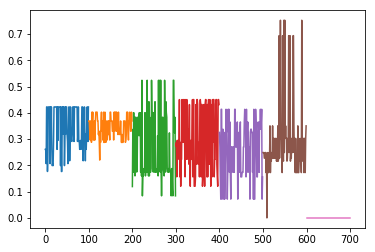

In [27]:
index = 0
for sim in s.qualities:
    plt.plot(range(index, index+len(sim)), sim)
    index += len(sim)
plt.show()

In [13]:
np.shape(range(10, 100))

(90,)

In [113]:
train, test = get_train_and_test_from_file('../data/breast-cancer.data', 'breast')


attributes = {}
attribute_list = ['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig', 'breast', 'breast-quad', 'irradiat']

attributes['age'] = ('10-19',' 20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99')
attributes['menopause'] = ('lt40', 'ge40', 'premeno')
attributes['tumor-size'] = ('0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44','45-49', '50-54', '55-59')
attributes['inv-nodes'] = ('0-2', '3-5', '6-8', '9-11', '12-14', '15-17', '18-20', '21-23', '24-26', '27-29', '30-32', '33-35', '36-39')
attributes['node-caps'] = ('yes', 'no')
attributes['deg-malig'] = (1,2,3)
attributes['breast'] = ('left', 'right')
attributes['breast-quad'] = ('left-up', 'left-low', 'right-up', 'right-low', 'central')
attributes['irradiat'] = ('yes', 'no')

classes = ['no-recurrence-events', 'recurrence-events']

s = Catagorization(100, 10, train, attributes, classes)
s.run_simulation()
print(s.discovered_rules)
s.evaluate_discovered_rules(test)

116
71
54
37
25
15
simulation done. Remaining cases:  15


In [43]:
accuracies = []
num_rules = []
for i in range(10):
    train, test = get_train_and_test_from_file('../data/breast-cancer-wisconsin.data', 'wisconsin')
    attribute_list = ['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses']
    attributes = {}
    for attribute in attribute_list:
        attributes[attribute] = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

    classes = ['2', '4']

    s = Catagorization(100, 10, train, attributes, classes)
    s.run_simulation()
    accuracies.append(s.evaluate_discovered_rules(test))
    num_rules.append(sum([len(rule) for rule in s.discovered_rules.values()]))
print(np.mean(accuracies))
print(np.std(accuracies))
print(np.mean(num_rules))
print(np.std(num_rules))

249
142
103
55
simulation done. Remaining cases:  55
255
153
111
55
simulation done. Remaining cases:  55
264
215
114
85
43
simulation done. Remaining cases:  43
244
208
107
54
simulation done. Remaining cases:  54
260
217
112
83
simulation done. Remaining cases:  83
240
215
161
87
66
simulation done. Remaining cases:  66
245
211
106
77
simulation done. Remaining cases:  77
253
151
110
60
simulation done. Remaining cases:  60
254
214
110
89
52
simulation done. Remaining cases:  52
456
144
100
49
simulation done. Remaining cases:  49
0.789177731868413
0.04930961563263849
4.3
0.45825756949558405


In [31]:
list(range(1,10))

[1, 2, 3, 4, 5, 6, 7, 8, 9]